In [50]:
# Code template referenced is from machinelearningplus.com and is correctly cited in report.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson


In [52]:
# Import dataset

path = "C:\\Users\\ajord\\Documents\\Renewables.csv"
df = pd.read_csv(path, delimiter=",",parse_dates=['year'], index_col='year')
df.head(5)

,co2,nuclear_generation,hydroelectricity_generation,geothermal_biomass_other_generation
year,,,,
1965-01-01,11189.7,25.5,923.2,18.0
1966-01-01,11694.9,34.4,983.8,19.8
1967-01-01,12055.5,41.0,1005.7,20.0
1968-01-01,12701.5,52.1,1059.3,22.1
1969-01-01,13483.7,61.8,1121.7,23.3


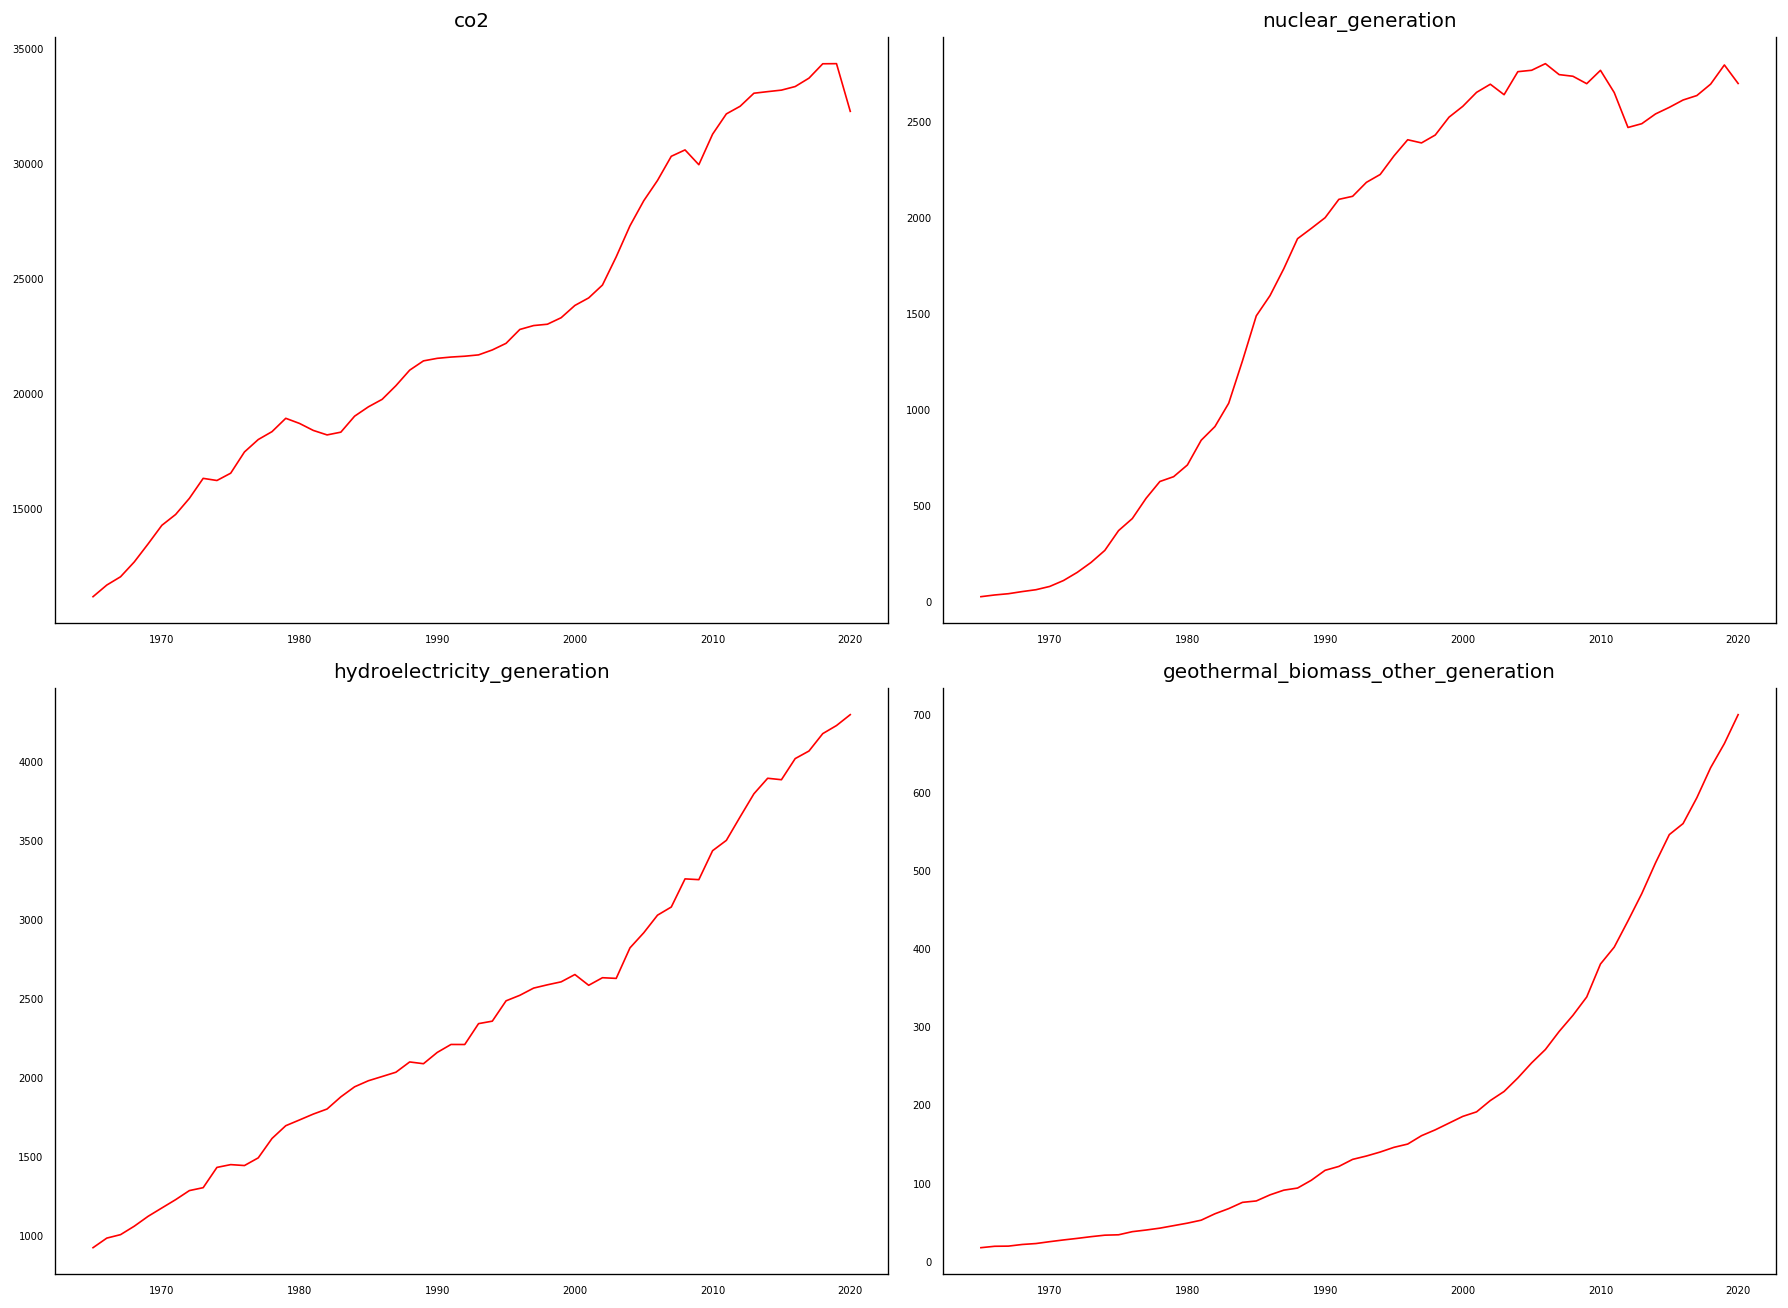

In [53]:
# Visualize different time series

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(15,11))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [54]:
# Testing causation using Granger Casulity Test

maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)     

,co2_x,nuclear_generation_x,hydroelectricity_generation_x,geothermal_biomass_other_generation_x
co2_y,1.0000,0.0000,0.0000,0.0000
nuclear_generation_y,0.0001,1.0000,0.0000,0.0018
hydroelectricity_generation_y,0.0000,0.0008,1.0000,0.0000
geothermal_biomass_other_generation_y,0.0004,0.0000,0.0051,1.0000


In [55]:
# Check to see if there's a statistically significant connection between two or more time series

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
co2    ::  92.69     > 40.1749   =>   True
nuclear_generation ::  41.01     > 24.2761   =>   True
hydroelectricity_generation ::  12.88     > 12.3212   =>   True
geothermal_biomass_other_generation ::  0.57      > 4.1296    =>   False


In [56]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(52, 4)
(4, 4)


In [57]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  


for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')  


    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2298
 No. Lags Chosen       = 1
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.9349. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5688
 No. Lags Chosen       = 1
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.4992. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    ----------------------------------------------

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5923
 No. Lags Chosen       = 0
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.0335
 No. Lags Chosen       = 0
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.0012. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-

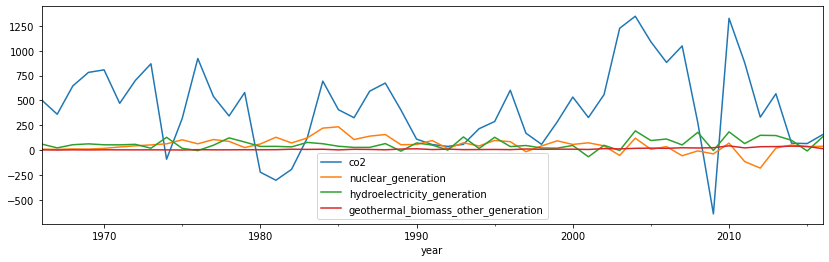

In [58]:
# First difference

df_differenced = df_train.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')  

df_differenced.plot(figsize=(14, 4));

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6207
 No. Lags Chosen       = 1
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1893
 No. Lags Chosen       = 1
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

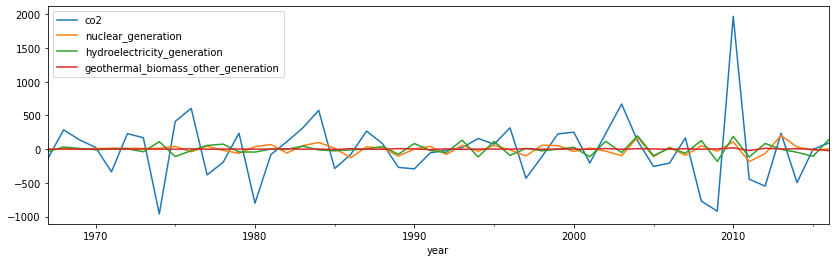

In [59]:
# Second difference

df_differenced = df_differenced.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

df_differenced.plot(figsize=(14, 4));

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7663
 No. Lags Chosen       = 6
 Critical value 1%     = -3.597
 Critical value 5%     = -2.933
 Critical value 10%    = -2.605
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1707
 No. Lags Chosen       = 9
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.0007. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

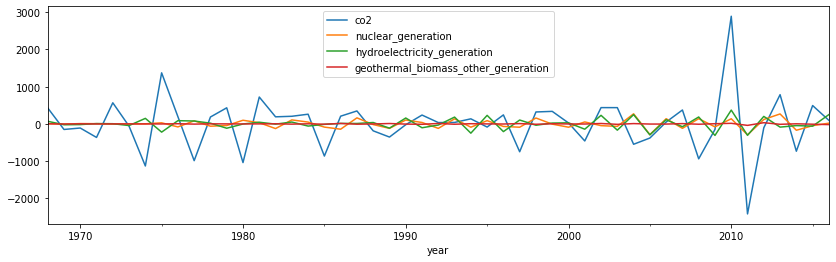

In [60]:
# Third difference

df_differenced = df_differenced.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

df_differenced.plot(figsize=(14, 4));

In [61]:
# Selecting order(p) by looking at AIC

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  34.72420354986964
BIC :  35.50387063774793
FPE :  1207390009626965.8
HQIC:  35.018840881230034 

Lag Order = 2
AIC :  33.861671886268944
BIC :  35.27880621949367
FPE :  517908197038341.4
HQIC:  34.39494905580798 

Lag Order = 3
AIC :  33.8205555800945
BIC :  35.887715419603914
FPE :  519457204400173.3
HQIC:  34.5949260453918 

Lag Order = 4
AIC :  32.90629781755215
BIC :  35.63636557987174
FPE :  228783005224265.06
HQIC:  33.924039668417144 

Lag Order = 5
AIC :  32.791370469782564
BIC :  36.19755067999015
FPE :  244139492261713.44
HQIC:  34.05454629827735 

Lag Order = 6
AIC :  32.568298388755224
BIC :  36.66411261129839
FPE :  271146230488517.53
HQIC:  34.07870809192049 

Lag Order = 7
AIC :  31.646061946283687
BIC :  36.44533993963775
FPE :  196793190886323.56
HQIC:  33.4051871452655 

Lag Order = 8
AIC :  30.59486704486276
BIC :  36.111733210837606
FPE :  226629323074607.62
HQIC:  32.60380553118614 



C:\Users\ajord\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [62]:
# Train VAR model with selected order

model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Dec, 2021
Time:                     13:07:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    35.6364
Nobs:                     45.0000    HQIC:                   33.9240
Log likelihood:          -927.801    FPE:                2.28783e+14
AIC:                      32.9063    Det(Omega_mle):     6.34903e+13
--------------------------------------------------------------------
Results for equation co2
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                                        -16.664584        81.326410           -0.205           0.838
L1.co2                                        -0.910322         0.20

In [63]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

co2 : 1.85
nuclear_generation : 2.09
hydroelectricity_generation : 2.14
geothermal_biomass_other_generation : 2.07


In [64]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 785.3,  267.7,  -86. ,  -10.7],
       [-733.4, -170.4,  -45.2,    3.2],
       [ 493.6,  -47.9,  -59.7,   -7.8],
       [  94.5,   20.8,  250.4,  -18.7]])

In [65]:
# Forecasting

fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_3d')
df_forecast

,co2_3d,nuclear_generation_3d,hydroelectricity_generation_3d,geothermal_biomass_other_generation_3d
year,,,,
2017-01-01,-288.005127,-134.661794,-334.379407,32.429948
2018-01-01,-952.384866,514.823193,381.045590,0.842167
2019-01-01,1275.001396,-344.296309,-419.674045,-22.375215
2020-01-01,881.731003,-291.700962,207.004148,6.034575


In [66]:
def invert_transformation(df_train, df_forecast, third_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        if third_diff:
            df_fc[str(col)+'_2d'] = (df_train[col].iloc[-2]-df_train[col].iloc[-3]) + df_fc[str(col)+'_3d'].cumsum()
        # Roll back 2nd Diff
        df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, third_diff=True)        
df_results.loc[:, ['co2_forecast', 'nuclear_generation_forecast', 
                    'hydroelectricity_generation_forecast', 'geothermal_biomass_other_generation_forecast']]

,co2_forecast,nuclear_generation_forecast,hydroelectricity_generation_forecast,geothermal_biomass_other_generation_forecast
year,,,,
2017-01-01,33295.094873,2551.738206,3808.820593,643.329948
2018-01-01,32053.299752,2903.937813,3636.407370,795.332011
2019-01-01,30911.516035,3326.202510,3081.786286,994.330975
2020-01-01,30751.474724,3526.831335,2351.961488,1246.361413


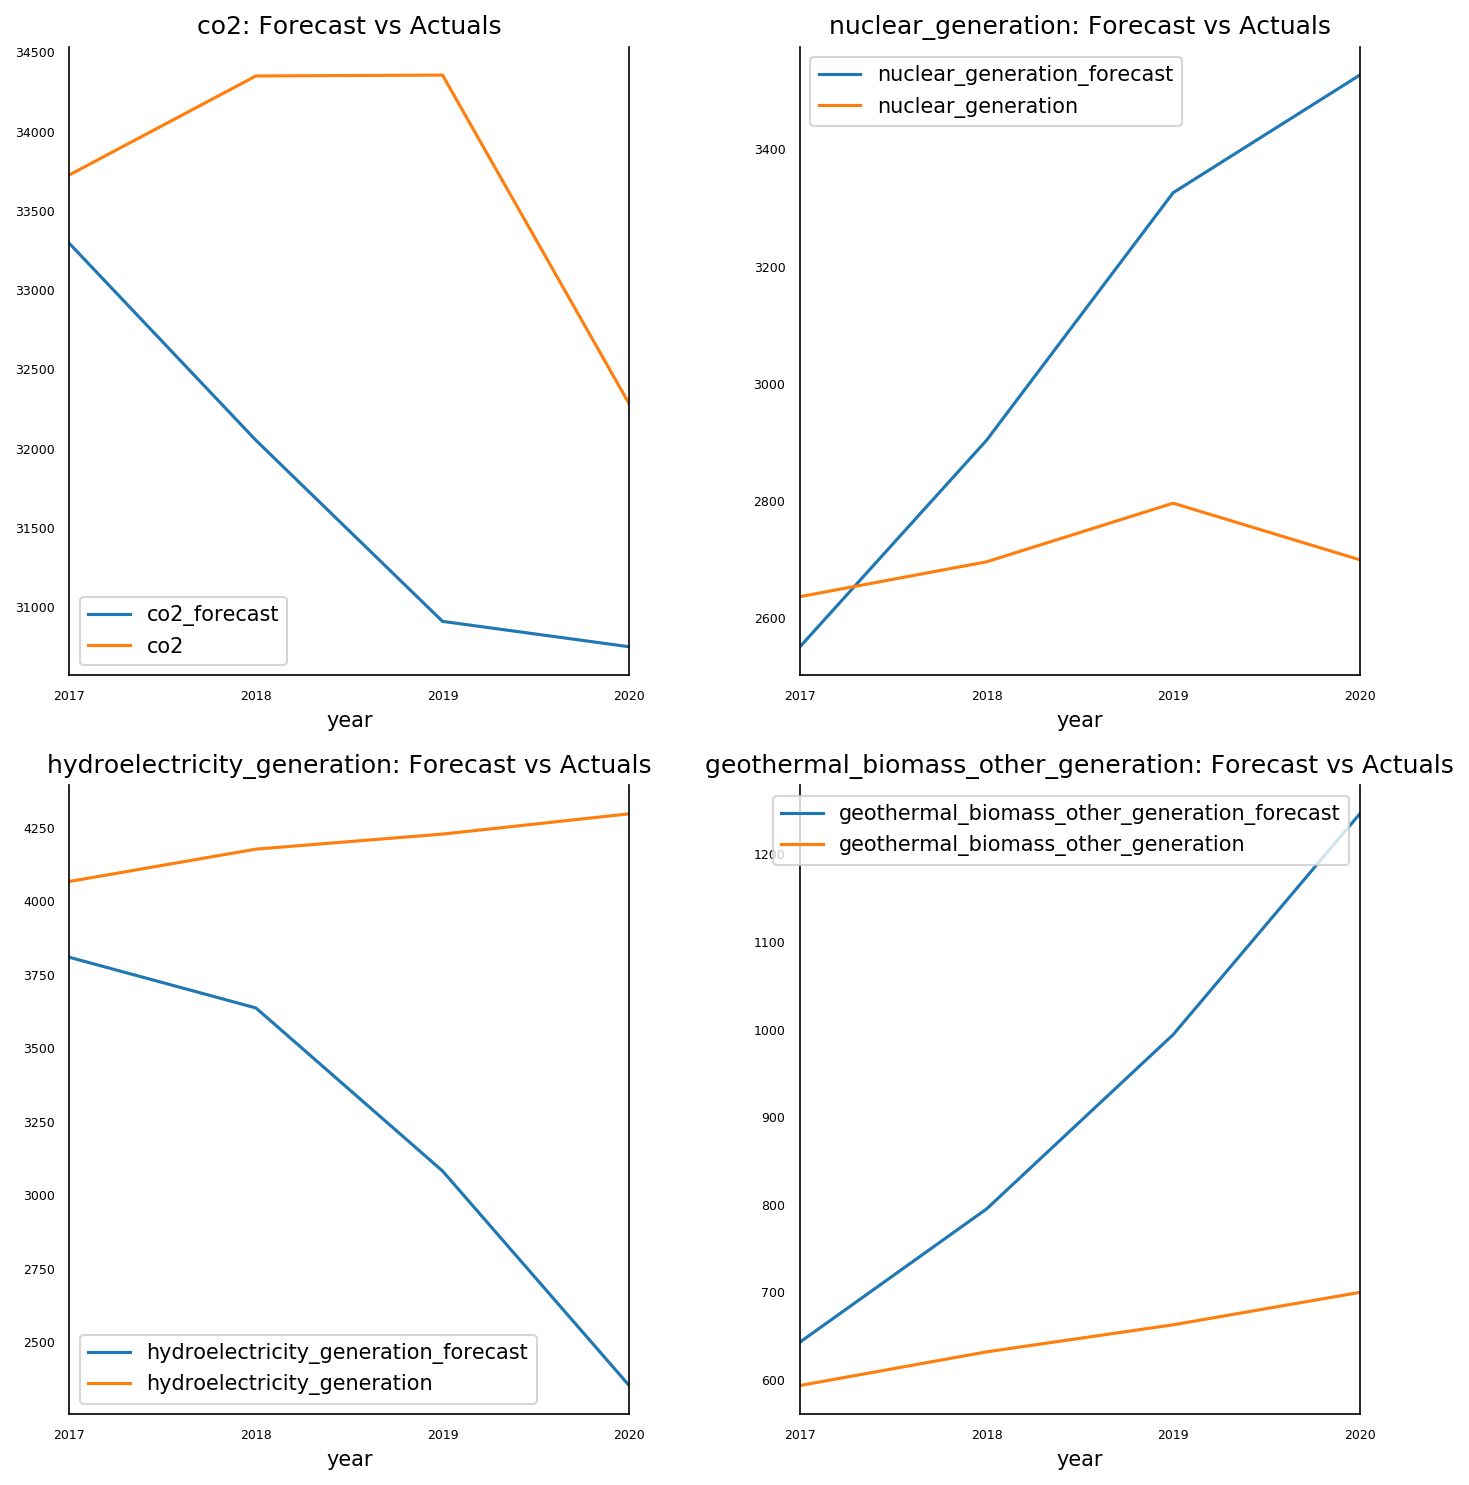

In [67]:
# Forecast Vs Actual

fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [68]:
# Evaluation using statistics

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'Mean Absolute Percentage Error':mape, 'Mean Error':me, 'Mean Absolute Error': mae, 
            'Mean Percentage Error ': mpe, 'Root Mean Squared Error':rmse,
            'corr':corr, 'Min-Max Error':minmax})

print('Forecast Accuracy of: co2')
forecast_accuracy(df_results['co2_forecast'].values, df_test['co2'])


Forecast Accuracy of: co2


{'Mean Absolute Percentage Error': 0.05686049038174347,
 'Mean Error': -1926.828653979096,
 'Mean Absolute Error': 1926.828653979096,
 'Mean Percentage Error ': -0.05686049038174347,
 'Root Mean Squared Error': 2218.3262501502395,
 'corr': 0.31896081945988175,
 'Min-Max Error': 0.056860490381743456}

In [69]:
print('\nForecast Accuracy of: nuclear_generation')
forecast_accuracy(df_results['nuclear_generation_forecast'].values, df_test['nuclear_generation'])


Forecast Accuracy of: nuclear_generation


{'Mean Absolute Percentage Error': 0.15121350616865353,
 'Mean Error': 369.55246589131593,
 'Mean Absolute Error': 412.28336269554916,
 'Mean Percentage Error ': 0.13501037527064302,
 'Root Mean Squared Error': 503.55143855666034,
 'corr': 0.6685754197126266,
 'Min-Max Error': 0.12435960111259348}

In [70]:
print('\nForecast Accuracy of: hydroelectricity_generation')
forecast_accuracy(df_results['hydroelectricity_generation_forecast'].values, df_test['hydroelectricity_generation'])


Forecast Accuracy of: hydroelectricity_generation


{'Mean Absolute Percentage Error': 0.22911987410426954,
 'Mean Error': -972.2810654827931,
 'Mean Absolute Error': 972.2810654827931,
 'Mean Percentage Error ': -0.22911987410426954,
 'Root Mean Squared Error': 1167.731925110928,
 'corr': -0.9221396866538101,
 'Min-Max Error': 0.22911987410426948}

In [71]:
print('\nForecast Accuracy of: geothermal_biomass_other_generation')
forecast_accuracy(df_results['geothermal_biomass_other_generation_forecast'].values, df_test['geothermal_biomass_other_generation'])


Forecast Accuracy of: geothermal_biomass_other_generation


{'Mean Absolute Percentage Error': 0.4053078297623948,
 'Mean Error': 272.53858689578647,
 'Mean Absolute Error': 272.53858689578647,
 'Mean Percentage Error ': 0.4053078297623948,
 'Root Mean Squared Error': 330.59823014121537,
 'corr': 0.9921855694994844,
 'Min-Max Error': 0.2633765397123987}